# ![upcode](images/front.png)

# First rule of presentations:
# Don't demo!

<h1><center>Let's demo!</center></h1>
<center><img src="images/homer.gif" alt="Crazy Homer"></center>

<center> <video controls src="data/singapore_drive.mp4" /> </center>

In [52]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip
from collections import deque

QUEUE_LENGTH=50

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def convert_to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
def select_white(image):
    converted = convert_to_hls(image)
    # white color mask
    lower = np.uint8([  0, 110,   0])
    upper = np.uint8([255, 180, 250])
    white_mask = cv2.inRange(converted, lower, upper)
    masked = cv2.bitwise_and(image, image, mask = white_mask)
    return masked
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def smoothing(image, kernel_size=15):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
def detect_edges(image, low_threshold=10, high_threshold=100):
    return cv2.Canny(image, low_threshold, high_threshold)
def filter_region(image, vertices):
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2])
    return cv2.bitwise_and(image, mask)
def select_region(image):
    rows, cols = image.shape[:2]
    bottom_left  = [int(cols*0.2), int(rows*0.95)]
    top_left     = [int(cols*0.5), int(rows*0.65)]
    bottom_right = [int(cols*0.95), int(rows*0.95)]
    top_right    = [int(cols*0.65), int(rows*0.65)] 
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    
    return filter_region(image, vertices)
def hough_lines(image):
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=5, minLineLength=5, maxLineGap=200)
def average_slope_intercept(lines):
    left_lines    = [] 
    left_weights  = [] 
    right_lines   = [] 
    right_weights = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
     
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane
def calculate_line_points(y1, y2, line):
    if line is None:
        return None
    
    slope, intercept = line
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0]
    y2 = y1*0.7         

    left_line  = calculate_line_points(y1, y2, left_lane)
    right_line = calculate_line_points(y1, y2, right_lane)
    
    return left_line, right_line
def draw_lane_lines(image, lines, color=[0, 0, 255], thickness=20):
    
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 0.9, 0.0)

In [53]:
class LanesDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=50)
        self.right_lines = deque(maxlen=50)
        
    def mean_line(self, line, lines):
        if line is not None:
            lines.append(line)

        if len(lines)>0:
            line = np.mean(lines, axis=0, dtype=np.int32)
            line = tuple(map(tuple, line))
        return line

    def process(self, image):
        white        = select_white(image)
        gray         = convert_to_grayscale(white)
        smooth_gray  = smoothing(gray)
        edges        = detect_edges(smooth_gray)
        regions      = select_region(edges)
        lines        = hough_lines(regions)
        left_line, right_line = lane_lines(image, lines)

        left_line  = self.mean_line(left_line,  self.left_lines)
        right_line = self.mean_line(right_line, self.right_lines)

        return draw_lane_lines(image, (left_line, right_line))
    
def process_video(video_input, video_output):
    detector = LanesDetector()

    clip = VideoFileClip(os.path.join('data', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('data', video_output), audio=False)

%time process_video('singapore_drive.mp4', 'detected_lanes.mp4')

[MoviePy] >>>> Building video data/detected_lanes.mp4
[MoviePy] Writing video data/detected_lanes.mp4


100%|██████████| 426/426 [01:00<00:00,  7.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/detected_lanes.mp4 

CPU times: user 2min 5s, sys: 11.8 s, total: 2min 16s
Wall time: 1min 3s


<center> <video controls src="data/detected_lanes.mp4" /> </center>

<h1><center>But... How?</center></h1>
<center><img src="images/wtf.png" alt="Wtf?"></center>

<h1><center>Why Self-Driving Cars?</center></h1>
<br>
<center><img src="images/autonomous_car.png" alt="Autonomous Car"></center>

<center><img src="images/blue_car.png" alt="Blue Car"></center>

# Cars are a good thing

<center><img src="images/chuck.gif" alt="Cars are good"></center>

# Time spent in cars

# Road injury one of the top 10 global causes of deaths

<h1><center>Why Computer Vision?</center></h1>
<br>
<center><img src="images/computer_vision.gif" alt="Computer Vision"></center>

<h1><center>Learn the ways of C.V. you must...</center></h1>

<center><img src="images/yoda.png" alt="yoda"></center>

# The tools

<center><img src="images/opencv.png" alt="opencv"></center>

<h3><a href="https://docs.opencv.org">docs.opencv.org</a></h3>

In [26]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip
from collections import deque

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# What's an image?

<center><img src="images/philosophator.png" alt="philosophator"></center>

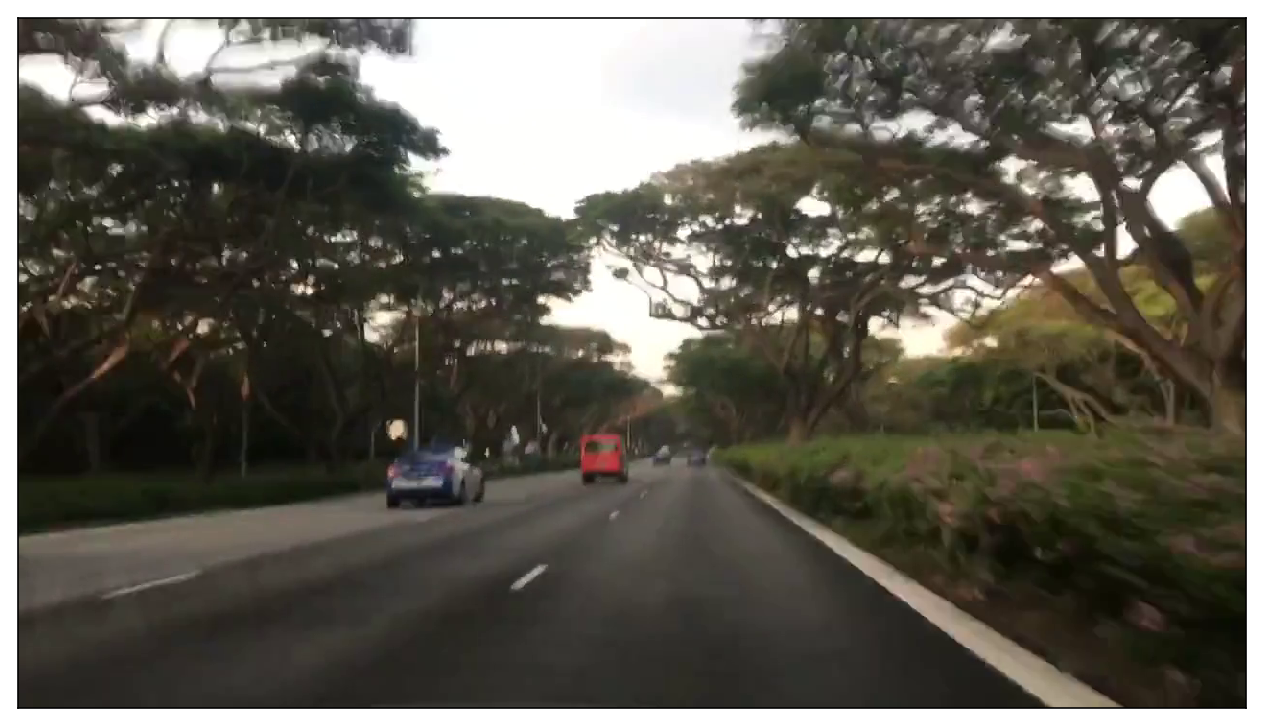

In [3]:
def show_image(image, cmap=None):
    plt.figure(figsize=(11,11))
    if len(image.shape)==2:
        cmap = 'gray'
    else:
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap)
    plt.xticks([])
    plt.yticks([])
    plt.show()

#Read the image with OpenCV
image = cv2.imread('data/test_image.png')

show_image(image)

In [4]:
image.shape

(720, 1280, 3)

In [5]:
image[1,1]

array([63, 69, 78], dtype=uint8)

# Core Concept: Masks

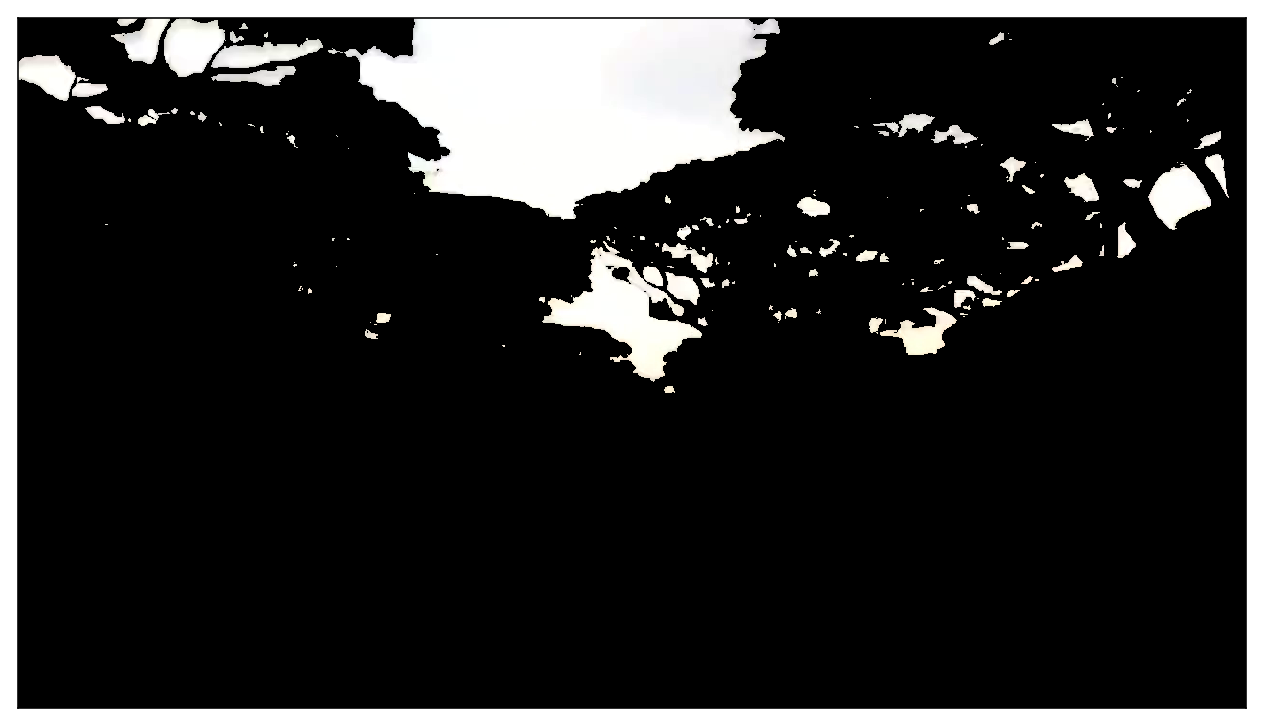

In [11]:
def select_white(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
   
    masked = cv2.bitwise_and(image, image, mask = white_mask)
    return masked

show_image(select_white(image))

# Core Concept: Images Representation

<center><img src="images/codification.png" alt="Color Representations"></center>

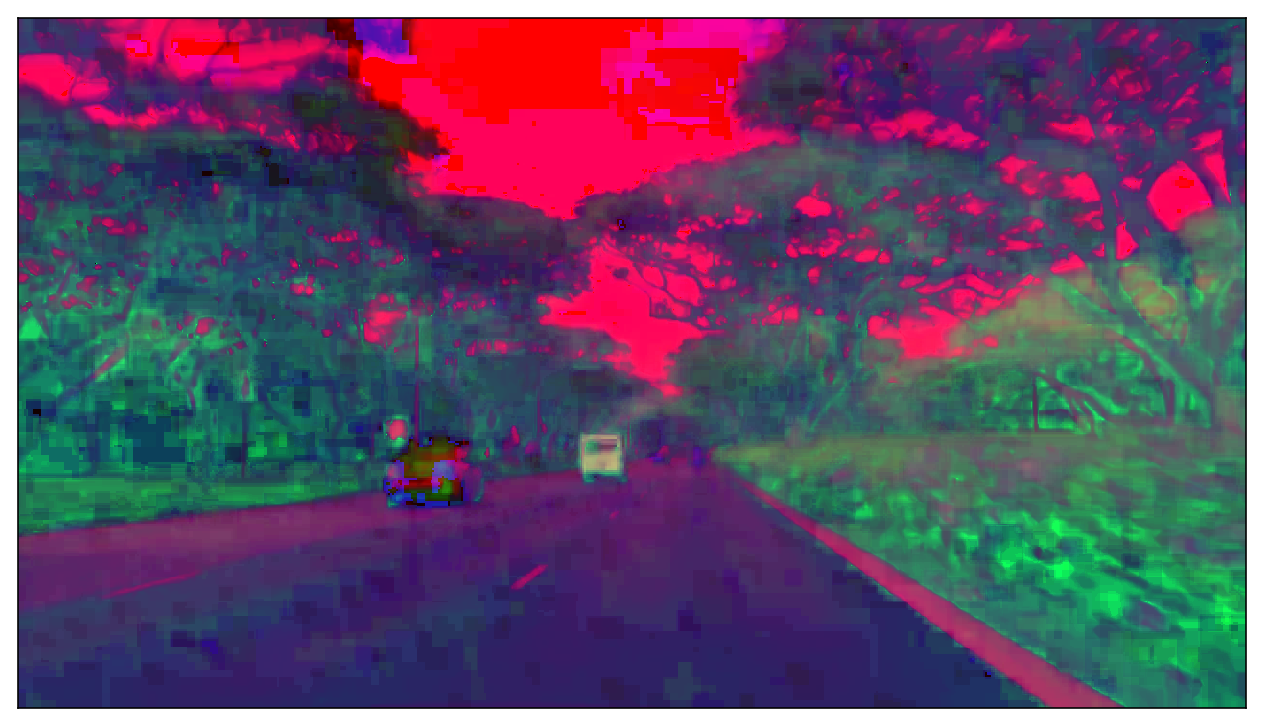

In [12]:
def convert_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

show_image(convert_to_hsv(image))

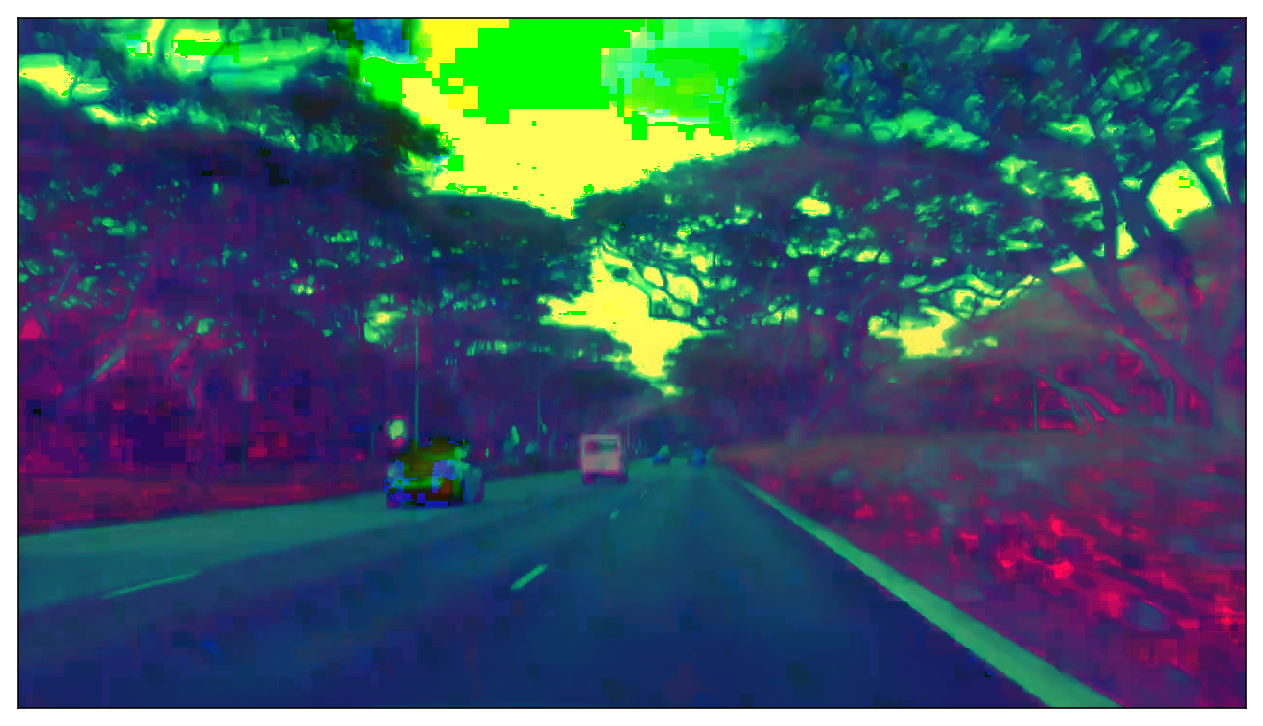

In [13]:
def convert_to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

show_image(convert_to_hls(image))

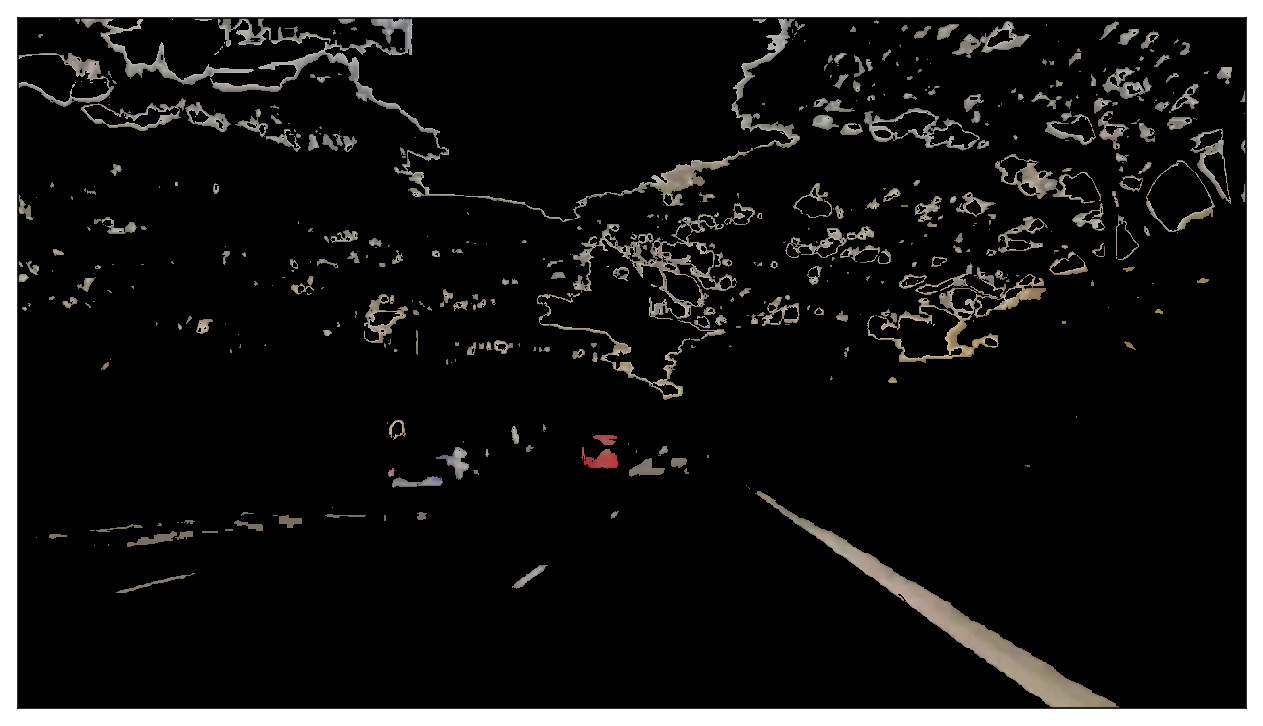

In [14]:
def select_white(image):
    converted = convert_to_hls(image)
    # white color mask
    lower = np.uint8([  0, 110,   0])
    upper = np.uint8([255, 180, 250])
    white_mask = cv2.inRange(converted, lower, upper)
    masked = cv2.bitwise_and(image, image, mask = white_mask)
    return masked

white_selection = select_white(image)
show_image(white_selection)

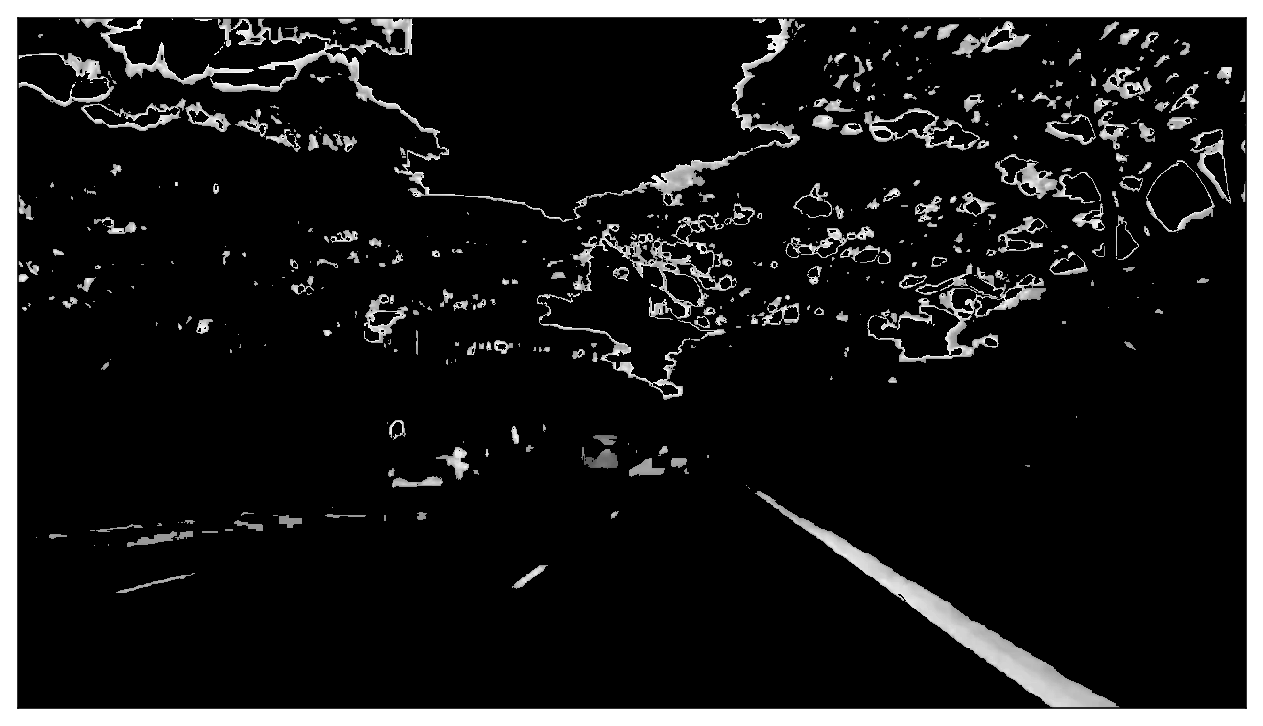

In [15]:
def convert_to_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_selection = convert_to_gray_scale(white_selection)
show_image(gray_selection)

# Core Concept: Gaussian Blur

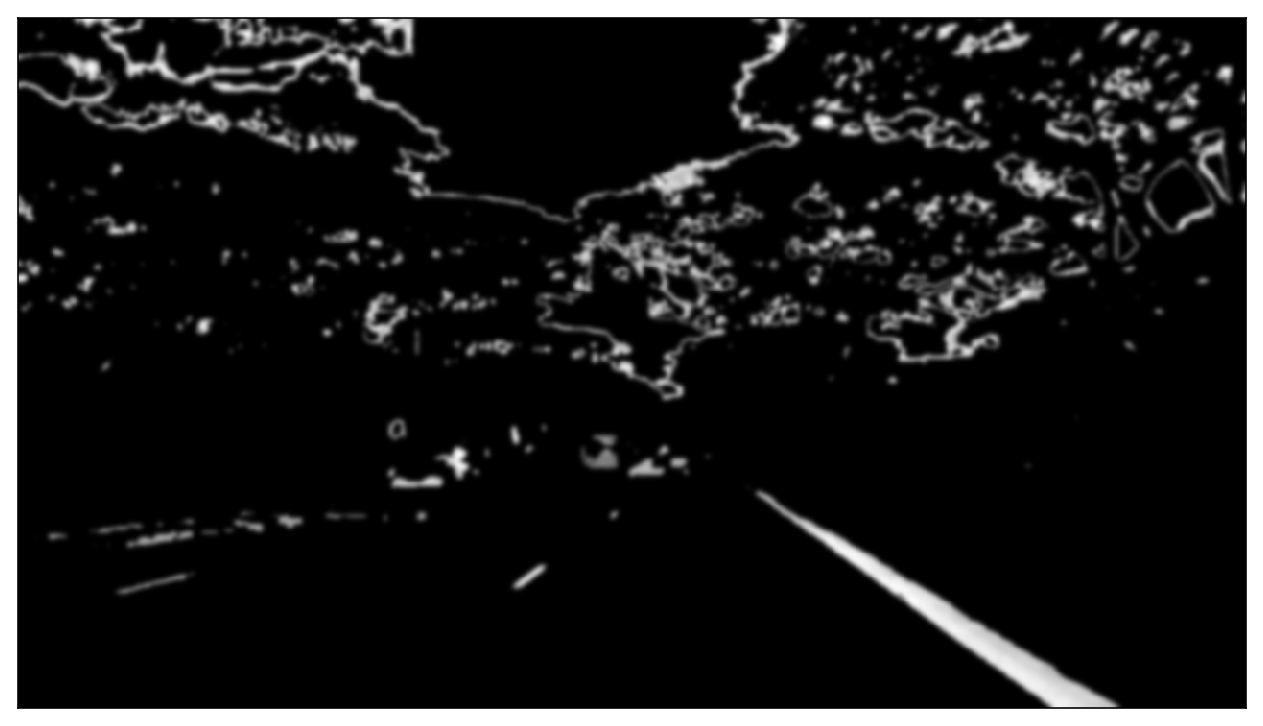

In [42]:
def smoothing(image, kernel_size=15):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

smooth_image =  smoothing(gray_selection)
show_image(smooth_image)

# Core Concept: Canny Edges

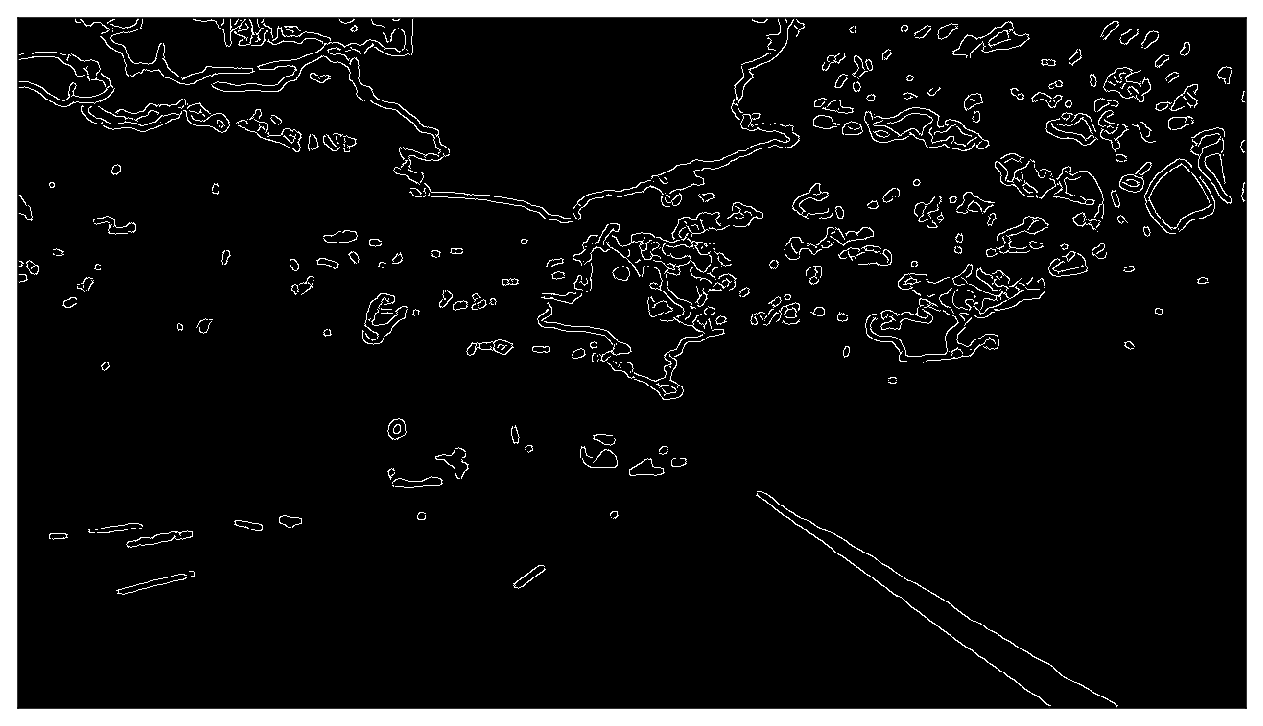

In [43]:
def detect_edges(image, low_threshold=10, high_threshold=100):
    return cv2.Canny(image, low_threshold, high_threshold)

edges_image =  detect_edges(smooth_image)
show_image(edges_image)

# Core Concept: ROI

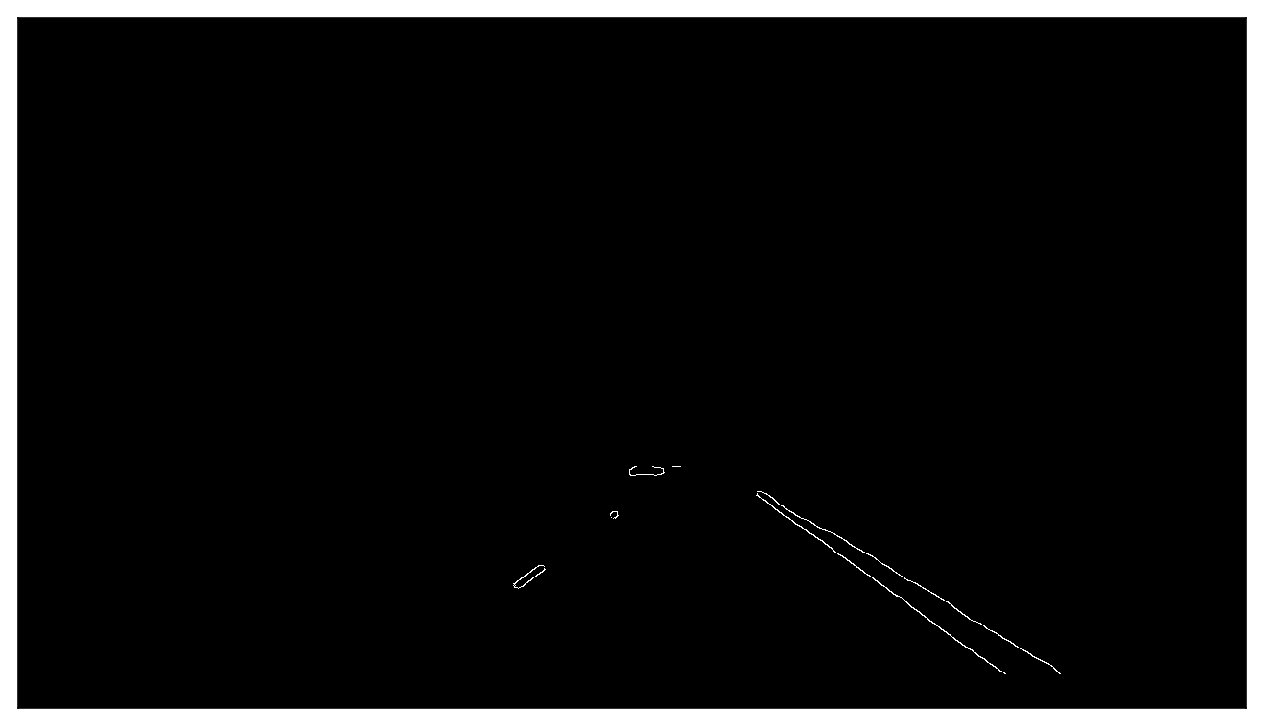

In [45]:
def filter_region(image, vertices):
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)
  
def select_region(image):
    rows, cols = image.shape[:2]
    bottom_left  = [int(cols*0.2), int(rows*0.95)]
    top_left     = [int(cols*0.5), int(rows*0.65)]
    bottom_right = [int(cols*0.95), int(rows*0.95)]
    top_right    = [int(cols*0.65), int(rows*0.65)] 
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    #image = cv2.line(image, tuple(bottom_left), tuple(top_left), (255,0,0), thickness=5)
    #image = cv2.line(image, tuple(bottom_right), tuple(top_right), (255,0,0), thickness=5)
    return filter_region(image, vertices)

roi_image = select_region(edges_image)
show_image(roi_image)

# Core Concept: Hough Transform

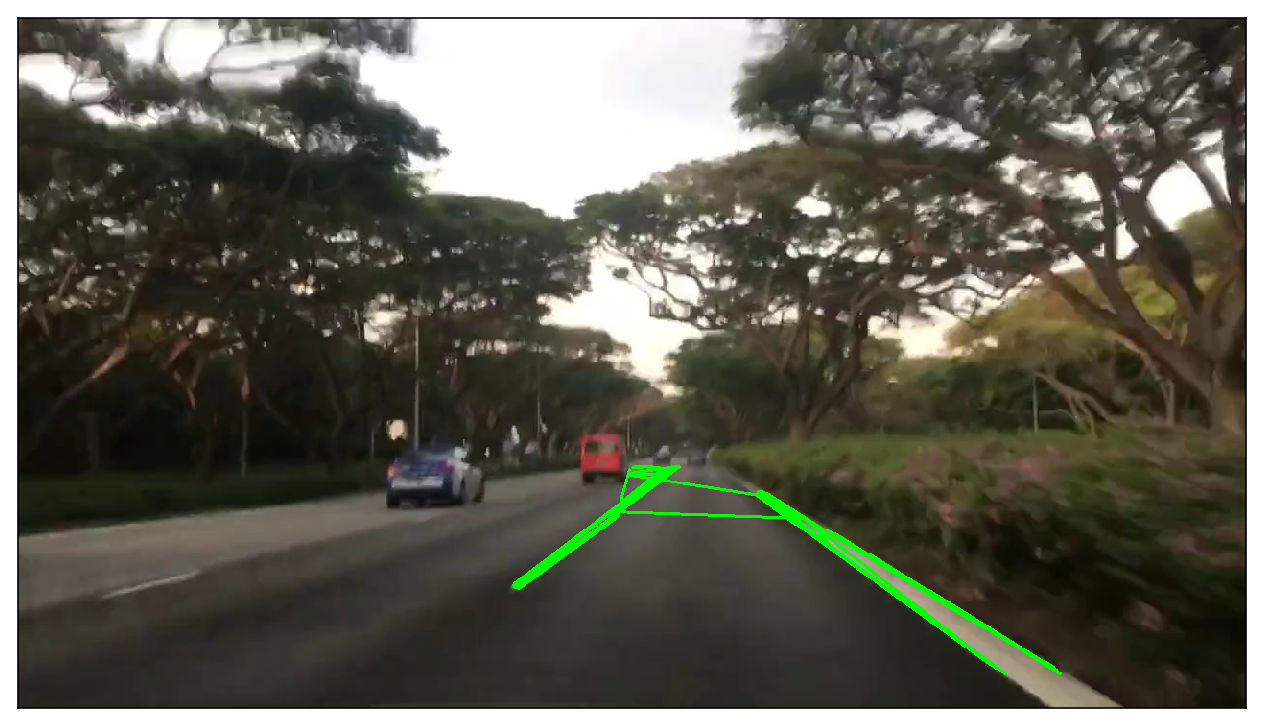

In [20]:
def draw_lines(image, lines, color=[0, 255, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image
def hough_lines(image):
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=5, minLineLength=5, maxLineGap=200)

lines = hough_lines(roi_image)
image_with_lines = draw_lines(image, lines)
show_image(image_with_lines)

In [46]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))   
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane 

In [22]:
def calculate_line_points(y1, y2, line):
    if line is None:
        return None
    
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

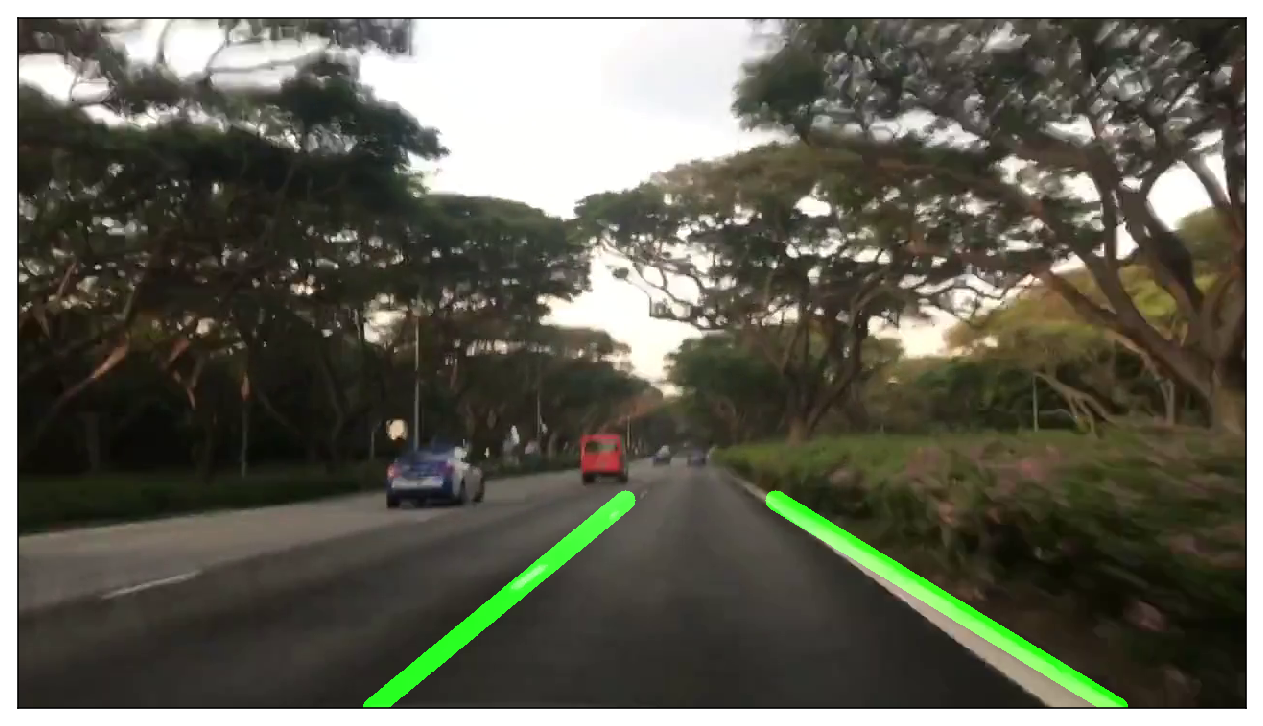

In [47]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1*0.7         
    left_line  = calculate_line_points(y1, y2, left_lane)
    right_line = calculate_line_points(y1, y2, right_lane)
    return left_line, right_line
 
def draw_lane_lines(image, lines, color=[0, 255, 0], thickness=20):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 0.9, 0.0)
             
lanes_detected = draw_lane_lines(image, lane_lines(image, lines))
    
show_image(lanes_detected)

In [50]:
class LanesDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=50)
        self.right_lines = deque(maxlen=50)
        
    def mean_line(self, line, lines):
        if line is not None:
            lines.append(line)

        if len(lines)>0:
            line = np.mean(lines, axis=0, dtype=np.int32)
            line = tuple(map(tuple, line))
        return line

    def process(self, image):
        white_yellow = select_white(image)
        gray         = convert_to_gray_scale(white_yellow)
        smooth_gray  = smoothing(gray)
        edges        = detect_edges(smooth_gray)
        regions      = select_region(edges)
        lines        = hough_lines(regions)
        left_line, right_line = lane_lines(image, lines)



        left_line  = self.mean_line(left_line,  self.left_lines)
        right_line = self.mean_line(right_line, self.right_lines)

        return draw_lane_lines(image, (left_line, right_line))

In [51]:
def process_video(video_input, video_output):
    detector = LanesDetector()

    clip = VideoFileClip(os.path.join('data', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('data', video_output), audio=False)
    
%time process_video('singapore_drive.mp4', 'our_brand_new_detected_lanes.mp4')  

[MoviePy] >>>> Building video data/our_brand_new_detected_lanes.mp4
[MoviePy] Writing video data/our_brand_new_detected_lanes.mp4


100%|██████████| 426/426 [01:02<00:00,  6.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/our_brand_new_detected_lanes.mp4 

CPU times: user 2min 1s, sys: 11.3 s, total: 2min 12s
Wall time: 1min 4s


<h1><center>A Self Driving Cars Degree!</center></h1>
<br>
<center><img src="images/omg.gif" alt="OMG!"></center>

# Thanks!
<br>
<h3> <center> marco@upcodeacademy.com </center> </h3>
<br><br>
<center><img src="images/banner.png" alt="OMG!"></center>